In [1]:
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
coord_pairs = []
with open('data/population_from_VEHITS_kommun_od_cut_work_distr.json') as json_file:
    data = json.load(json_file)
    for person in data['persons']:
        start_coord = person['activities'][0]['coord']
        end_coord = person['activities'][1]['coord']
        time = person['activities'][1]['start_time']
        szone = person['activities'][0]['zone']
        ezone = person['activities'][1]['zone']
        coord_pairs.append((start_coord['lat'],start_coord['lon'], end_coord['lat'], end_coord['lon'], time, szone, ezone))

In [3]:
outgoing = 0
incomming = 0
within = 0
sjobo = [z for z in range(12650000, 12650019)]
for person in data['persons']:
    szone = int(person['activities'][0]['zone'])
    ezone = int(person['activities'][1]['zone'])
    
    if szone in sjobo and ezone in sjobo:
        within += 1
    elif szone in sjobo and ezone not in sjobo:
        outgoing += 1
    else:
        incomming += 1

In [4]:
print (outgoing, incomming, within)

3832 2088 2163


In [5]:
import pandas as pd
df = pd.DataFrame(coord_pairs, columns=['slat','slon','elat','elon','time', 'szone','ezone'])
# df['latlon'] = df.lat.astype(str)+df.lon.astype(str)

In [6]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [7]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [8]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [9]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [10]:
class LegMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    BUS = 'BUS'
    RAIL = 'RAIL'
    BICYCLE = 'BICYCLE'
    TRAM = 'TRAM'
    SUBWAY = 'SUBWAY'
    CAR_PARK = 'CAR_PARK'
    BICYCLE_PARK = 'BICYCLE_PARK'
    BICYCLE_RENT = 'BICYCLE_RENT'
    DRT = 'DRT'

    _DICT = ['CAR', 'WALK', 'BUS', 'RAIL', 'BICYCLE', 'TRAM', 'SUBWAY',
             'CAR_PARK', 'BICYCLE_PARK', 'BICYCLE_RENT', 'DRT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'BUS', 'RAIL', 'WALK']

    @staticmethod
    def get_all_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._DICT]

    @staticmethod
    def get_main_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in LegMode._DICT

    @staticmethod
    def get_mode(string):
        if LegMode.contains(string):
            return LegMode
        else:
            raise Exception('unsupported mode {}'.format(string))

In [11]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [12]:
def parse_otp_response(resp):
    if resp.status_code != requests.codes.ok:
        resp.raise_for_status()

    jresp = resp.json()
    if 'error' in jresp.keys():
        if jresp.get('error').get('id') == 409:
            raise Exception()
        elif jresp.get('error').get('id') == 404:
            raise Exception()
        else:
            raise Exception()

    itineraries = jresp.get('plan').get('itineraries')

    trips = []
    geometries = []
    for itinerary in itineraries:
        trip = Trip()
        trip.set_duration(itinerary.get('duration'))
        trip.set_distance(sum([leg.get('distance') for leg in itinerary.get('legs')]))
        geometry = []
        for raw_leg in itinerary.get('legs'):            
            leg = Leg()
            leg.distance = raw_leg.get('distance')
            leg.duration = raw_leg.get('duration')
            raw_from = raw_leg.get('from')
            leg.start_coord = Coord(lat=raw_from.get('lat'),
                                    lon=raw_from.get('lon'))
            raw_to = raw_leg.get('to')
            leg.end_coord = Coord(lat=raw_to.get('lat'),
                                  lon=raw_to.get('lon'))
            leg.mode = raw_leg.get('mode')
#             leg.steps = [self.step_from_raw(s) for s in raw_leg.get('steps')]

#              leg.start_time = int(raw_leg.get('startTime'))/1000 - self.env.config.get('date.unix_epoch')
#              leg.end_time = int(raw_leg.get('endTime'))/1000 - self.env.config.get('date.unix_epoch')

            if leg.mode in OtpMode.get_pt_modes():
                # OTP has id in the following format: 'SE-st:9022012065015001'
                # we are not interested in the first part
                leg.from_stop = int(raw_from.get('stopId').split(':')[1])
                leg.to_stop = int(raw_to.get('stopId').split(':')[1])
            trip.append_leg(leg)

            trip.main_mode = trip.main_mode_from_legs()       
            geometry.append(raw_leg.get('legGeometry').get('points'))
        geometries.append(geometry)
        trips.append(trip)
        break

    return trips, geometries

def otp_request( from_place,
                 to_place,
                 at_time,
                 mode: str,
                 attributes=None):
    default_attributes = {'fromPlace': str(from_place),
                          'toPlace': str(to_place),
                          'date': '11-14-2018',
                          'mode': mode,
                          'arriveBy': 'True',
                          'maxWalkDistance': 10000,
                          #'walkSpeed': 16.6667
                         }
    if attributes is not None:
        default_attributes.update(attributes)
    
    try:
        resp = requests.get('http://localhost:8080/otp/routers/skane/plan', params=default_attributes)
    
        # payload = Payload(attributes=default_attributes, config=self.env.config)

        # resp = requests.get(self.url, params=payload.get_payload())
        
        parsed_trips, geometries = parse_otp_response(resp)
    except Exception as e:
        print(e)
        return None, None

    for trip in parsed_trips:
        trip.set_main_mode(mode)

    return parsed_trips, geometries

In [13]:
df['szone']=df.szone.astype(int)
df['ezone']=df.ezone.astype(int)

In [18]:
def choose(alternatives):
    filtered_alternatives = []
    for trip in alternatives:
        trip.utility = self.calc_utility(trip)
        filtered_alternatives.append(trip)

    if len(filtered_alternatives) != 0:
        mnl(filtered_alternatives)
        return montecarlo(filtered_alternatives)
    else:
        return None
    
def calc_utility(trip):
    """Pretty much random numbers so far
    TODO: make a model class to be added to config
    """
    vot = {LegMode.CAR: 0.023/60,
           LegMode.BUS: 0.023/60,
           LegMode.RAIL: 0.023/60,
           LegMode.TRAM: 0.023/60,
           LegMode.WALK: 0.032/60,
#            LegMode.BICYCLE: 0.0007,
#            LegMode.SUBWAY: 0.005,
#            LegMode.BICYCLE_RENT: 0.004,
           LegMode.DRT: 0.023/60
           }
    c = 0.074/60
    try:
        if len(trip.legs) > 0:
            s = sum([leg.duration*vot.get(leg.mode) for leg in trip.legs])
            if trip.main_mode == LegMode.CAR:
                car_dist = [leg.distance for leg in trip.legs if leg.mode == LegMode.CAR]
                cost = sum([d*2.79 for d in car_dist])
            else:
                cost = 51
            s += c*cost
        else:
            print('am I ever here?')
            s = trip.duration*vot.get(trip.main_mode)
    except RuntimeError:
        print([leg.mode for leg in trip.legs])
        raise Exception('wrong math in MNL')
    return s

def mnl(alternatives):
    s = sum([math.exp(trip.utility) for trip in alternatives])
    for trip in alternatives:
        trip.prob = math.exp(trip.utility) / s
        
def montecarlo(self, alternatives):
    # use numpy random choice
    if sum([trip.prob for trip in alternatives]) < 0.99999998:
        print(alternatives)
        raise Exception('Probability is not 1, but {}'.format(sum([trip.prob for trip in alternatives])))
    r = self.env.rand.uniform(0, 1)
    c = 0.0

    for a in alternatives:
        if a.main_mode in OtpMode.get_drt_modes():
            return a
    for a in alternatives:
        if a.main_mode == OtpMode.CAR:
            return a

    for trip in alternatives:
        c += trip.prob
        if c > r:
            return trip
    raise Exception('Montecarlo failed')

In [14]:
pt_persons_within = []
pt_persons_outside = []
other_persons_within = []
other_persons_outside = []
drtable_outside = []

trips_pt_within = []
trips_other_within = []

trips_pt_outside = []
trips_drtable_outside = []
trips_other_outside = []

sjobo = [z for z in range(12650001, 12650018)]

for (_,trip), person in zip(df.iterrows(), data['persons']):
        
    print(_)
        
    trip_pt, pol_pt = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip.time, mode = 'TRANSIT,WALK')
    
    trip_car, pol_car = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip.time, mode = 'CAR')
    if pol_car is None:
        continue
        
    if pol_pt is None:
        if trip.szone in sjobo and trip.ezone in sjobo:
            other_persons_within.append(person)
            trips_other_within.append((trip_pt,trip_car))
        else:
            other_persons_outside.append(person)
            trips_other_outside.append((trip_pt,trip_car))
            
    else:    
        if trip_car[0].duration * 1.7 > trip_pt[0].duration:
            if trip.szone in sjobo and trip.ezone in sjobo:
                pt_persons_within.append(person)
                trips_pt_within.append((trip_pt,trip_car))
            else:
                pt_persons_outside.append(person)
                trips_pt_outside.append((trip_pt,trip_car))
        else:
            if trip.szone in sjobo and trip.ezone in sjobo:
                other_persons_within.append(person)
                trips_other_within.append((trip_pt,trip_car))
            else:
                # separate persons with a duration of a walk leg outside sjobo less than 30 minutes
                if trip.szone in sjobo and trip.ezone not in sjobo:
                    leg = trip_pt[0].legs[-1] 
                elif trip.szone not in sjobo and trip.ezone in sjobo:
                    leg = trip_pt[0].legs[0]
                else:
                    print('wtf, trip is neither in or out of sjobo')
                
                if leg.distance < 1000:
                    drtable_outside.append(person)
                    trips_drtable_outside.append((trip_pt,trip_car))
                else:
                    other_persons_outside.append(person)
                    trips_other_outside.append((trip_pt,trip_car))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271

272
273
274
275
276


1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967

1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994

1995

1996


1997
1998

1999

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
205

3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652

3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692

5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146

5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167

5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231

5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301

5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5

6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781

6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796

6797
6798
6799

6800
6801

6802

6803

6804
6805

6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831

6832
6833

6834
6835

6836

6837

6838
6839

6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929

6930
6931
6932

6933
6934
6935

6936
6937

6938
6939
6940
6941
6942
6943
6944
6945

6946
6947
6948
6949
6950
69

In [15]:
print('drtable_outside', len(drtable_outside), len(trips_drtable_outside))
print('pt_outside' ,len(pt_persons_outside), len(trips_pt_outside))
print('pt_within', len(pt_persons_within), len(trips_pt_within))
print('other_outside', len(other_persons_outside), len(trips_other_outside))
print('other_within', len(other_persons_within), len(trips_other_within))

drtable_outside 2881 2881
pt_outside 421 421
pt_within 86 86
other_outside 2559 2559
other_within 2066 2066


In [16]:
len(pt_persons_outside)+len(pt_persons_within)+len(other_persons_outside)+len(other_persons_within)+len(drtable_outside)

8013

# Recalculate number of people within PT time windows
# and within walkable distane

In [17]:
trips_all_outside = trips_other_outside + trips_pt_outside + trips_drtable_outside
persons_all_outside = other_persons_outside + pt_persons_outside + drtable_outside

In [18]:
def trips_from_walk_distance(trips_all_outside,persons_all_outside,threshold):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip = tr[0][0]
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo:
            leg_dist = trip.legs[-1].distance
        else:
            leg_dist = trip.legs[0].distance

        if leg_dist < threshold:
            n += 1
    return n

In [19]:
x = [trips_from_walk_distance(trips_all_outside, persons_all_outside, x) for x in range(0,10000,100)]

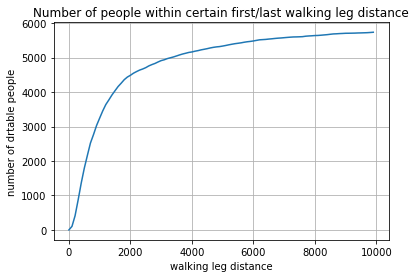

In [20]:
fig, ax = plt.subplots()
ax.plot(range(0,10000,100), x)
ax.set(xlabel='walking leg distance', ylabel='number of drtable people',
       title='Number of people within certain first/last walking leg distance')
ax.grid()

In [21]:
def trips_from_time_ratio(trips_all_outside,persons_all_outside,threshold):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        if trip_pt.duration < trip_car.duration * threshold:
            n += 1
    return n

In [22]:
x = [trips_from_time_ratio(trips_all_outside, persons_all_outside, x) for x in np.arange(0, 10, 0.2)]

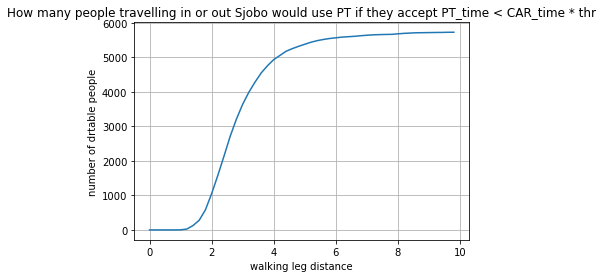

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.2), x)
ax.set(xlabel='walking leg distance', ylabel='number of drtable people',
       title='How many people travelling in or out Sjobo would use PT if they accept PT_time < CAR_time * thr')
ax.grid()

# With this we can calibrate time window size

In [24]:
def trips_from_time_ratio_in_out(trips_all_outside,persons_all_outside,threshold, in_zone=True):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo and in_zone == True:
            continue
        elif szone not in sjobo and in_zone == False:
            continue
        
        if trip_pt.duration <= trip_car.duration * threshold:
            n += 1
    return n

In [25]:
pt_in = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=True) for x in np.arange(0, 10, 0.05)]
pt_out = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=False) for x in np.arange(0, 10, 0.05)]
print('in', pt_in)
print('out', pt_out)

in [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 10, 13, 20, 30, 43, 63, 76, 102, 120, 140, 170, 204, 234, 275, 311, 350, 397, 454, 517, 556, 598, 639, 679, 724, 772, 821, 875, 919, 961, 1000, 1026, 1068, 1106, 1142, 1180, 1213, 1252, 1284, 1310, 1341, 1368, 1393, 1422, 1445, 1467, 1493, 1517, 1537, 1553, 1576, 1599, 1624, 1648, 1666, 1688, 1705, 1721, 1739, 1751, 1766, 1780, 1789, 1795, 1802, 1813, 1824, 1832, 1835, 1838, 1844, 1847, 1857, 1864, 1871, 1881, 1882, 1893, 1902, 1911, 1917, 1921, 1926, 1928, 1938, 1943, 1949, 1953, 1958, 1959, 1965, 1970, 1973, 1975, 1979, 1983, 1984, 1985, 1988, 1990, 1991, 1992, 1992, 1996, 1998, 1998, 2001, 2002, 2003, 2003, 2004, 2004, 2007, 2009, 2012, 2014, 2014, 2016, 2016, 2016, 2019, 2021, 2022, 2022, 2023, 2023, 2023, 2024, 2025, 2026, 2027, 2027, 2027, 2027, 2028, 2029, 2031, 2032, 2037, 2037, 2038, 2041, 2042, 2044, 2044, 2044, 2044, 2045, 2045, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2048, 2048, 2048, 2048, 2048, 204

In [26]:
print(pt_in[31], np.arange(0, 10, 0.05)[31])
print(pt_out[39], np.arange(0, 10, 0.05)[39])

120 1.55
520 1.9500000000000002


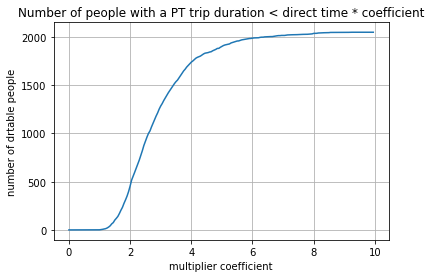

In [27]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_in)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

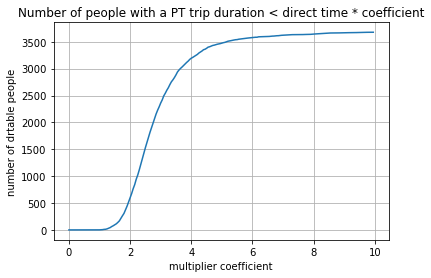

In [28]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_out)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

# Redistribute people according to calibrated time windows

In [29]:
def trips_from_time_ratio(trips_all, persons_all, walk_threshold, time_coefficient, trip_in):
    pt_persons = []
    other_persons = []
    drtable_persons = []
    for tr, person in zip(trips_all, persons_all):
        
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo and trip_in:
            continue
        elif szone not in sjobo and not trip_in:
            continue
        
        if tr[0] is None:
            other_persons.append(person)
            continue
        
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        if trip_pt.duration <= trip_car.duration * time_coefficient:
            pt_persons.append(person)
        else:
            if szone in sjobo:
                leg_dist = trip_pt.legs[-1].distance
            else:
                leg_dist = trip_pt.legs[0].distance

            if leg_dist <= walk_threshold:
                drtable_persons.append(person)
            else:
                other_persons.append(person)
    
    return pt_persons, drtable_persons, other_persons

In [30]:
pt_persons_in, drtable_persons_in, other_persons_in = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.55, trip_in=True)
print(len(pt_persons_in), len(drtable_persons_in), len(other_persons_in))

120 880 1065


In [31]:
pt_persons_out, drtable_persons_out, other_persons_out = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.95, trip_in=False)
print(len(pt_persons_out), len(drtable_persons_out), len(other_persons_out))

520 1852 1424


In [32]:
print('population_within_pt', len(pt_persons_within))
print('population_within_other', len(other_persons_within))
              
print('population_in_pt', len(pt_persons_in))
print('population_out_pt', len(pt_persons_out))
              
print('population_in_drtable', len(drtable_persons_in))
print('population_out_drtable', len(drtable_persons_out))
              
print('population_in_other', len(other_persons_in))
print('population_out_other', len(other_persons_out))

population_within_pt 86
population_within_other 2066
population_in_pt 120
population_out_pt 520
population_in_drtable 880
population_out_drtable 1852
population_in_other 1065
population_out_other 1424


In [33]:
population = {'population_within_pt': pt_persons_within, 
              'population_within_other': other_persons_within,
              
              'population_in_pt': pt_persons_in,
              'population_out_pt': pt_persons_out,
              
              'population_in_drtable': drtable_persons_in,
              'population_out_drtable': drtable_persons_out,
              
              'population_in_other': other_persons_in,
              'population_out_other': other_persons_out
             }

In [34]:
with open('data/population_VEHITS_divided_to_pt_and_others_kommun_cut_work_distr.json', 'w') as outfile:
    json.dump(population, outfile)